In [1]:
from luigi.contrib.external_program import ExternalProgramTask
from luigi.parameter import IntParameter, Parameter
from luigi import LocalTarget, Task
from matplotlib import pyplot as plt
%matplotlib inline
from keras import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import numpy
import cv2
# generate slides:
# jupyter nbconvert Production-Ready-Datascience.ipynb --to slides --post serve --reveal-prefix=reveal.js

/Users/markkeinhorster/.venv/tf_weather_service/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [55]:
def plot_images(start_from=0, columns=3, rows=3, test=True):
    fig=plt.figure(figsize=(6, 6))
    for i in range(1+start_from, columns*rows+1+start_from):
        if not test:
            img = cv2.imread("dataset/fruit-images-dataset/%s/%s" % ("Training", train_data.filenames[i]))
        else:
            img = cv2.imread("dataset/fruit-images-dataset/%s/%s" % ("Test", test_data.filenames[i]))
        
        b,g,r = cv2.split(img)       # get b,g,r
        img = cv2.merge([r,g,b])     # switch it to rgb
        fig.add_subplot(rows, columns, i-start_from)
        plt.xticks([]), plt.yticks([]) 
        plt.imshow(img)
    plt.show()

<img src="slides/title.png">

# <center> About this Workshop </center>

<center>Interactively build a model that differentiates between limes and bananas</center> 
<center>Get a glimpse of production-readiness</center> 
<center>Learn about Luigi pipelines and their main components</center>
<center>Write your production ready pipeline</center>
<center>Get an overview of luigis modules</center>
  
    


# <center> Building the model interactively </center>

## <center> Download dataset </center>

In [3]:
!mkdir -p dataset
!curl -L -o dataset/dataset_v1.zip http://plainpixels.work/resources/datasets/dataset_v1.zip
!unzip -u -q -d dataset/fruit-images-dataset dataset/dataset_v1.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 60 4630k   60 2787k    0     0   120k      0  0:00:38  0:00:23  0:00:15  106k5k      0  0:00:43  0:00:03  0:00:40  105k^C
[dataset/dataset_v1.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of dataset/dataset_v1.zip or
        dataset/dataset_v1.zip.zip, and cannot find dataset/dataset_v1.zip.ZIP, period.


In [4]:
!ls dataset/fruit-images-dataset/Test

Banana Lemon


# <center> Explore the data </center>

In [5]:
img_height, img_width = 100, 100

images_train_path = 'dataset/fruit-images-dataset/Training/'
images_test_path = 'dataset/fruit-images-dataset/Test/'

imageGenTrain = ImageDataGenerator(rescale=1. / 255)
imageGenTest = ImageDataGenerator(rescale=1. / 255)
train_data = imageGenTrain.flow_from_directory(images_train_path, 
                                               target_size=(img_height, img_width), color_mode='rgb', batch_size=32)
test_data = imageGenTest.flow_from_directory(images_test_path, 
                                             target_size=(img_height, img_width), color_mode='rgb', batch_size=32)

Found 982 images belonging to 2 classes.
Found 330 images belonging to 2 classes.


shape  : 	(100, 100, 3)
classes: 	2, {'Lemon': 1, 'Banana': 0}
size   : 	982


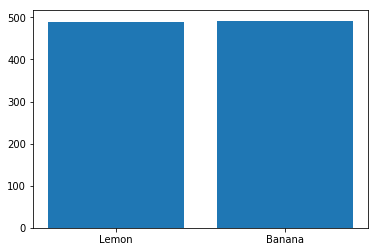

In [6]:
input_shape = train_data.image_shape
classes = train_data.class_indices
num_classes = len(classes)
class_counts = numpy.unique(train_data.classes, return_counts=True)[1]
print "shape  : \t(%s, %s, %s)" % input_shape
print "classes: \t%s, %s" % (num_classes, classes)
print "size   : \t%s" % train_data.n
chart = plt.bar(classes.keys(), class_counts)
plt.show(chart)

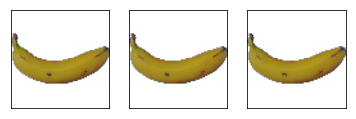

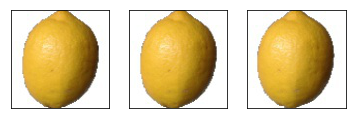

In [7]:
plot_images(start_from=0, rows=1)
plot_images(start_from=170, rows=1)

# <center> Build a baseline model </center>
## <center> Distinguish Limes from Bananas using OpenCV </center>

In [8]:
path = "dataset/fruit-images-dataset/Test/"
correct = 0.0
for i in range(0, test_data.n):
    label = test_data.classes[i]
    img = cv2.imread("%s/%s" % (path, test_data.filenames[i]))
    im = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(im, cv2.HOUGH_GRADIENT, 
                               dp=2, minDist=15, param1=100, param2=70)
    if circles is not None:
        if label == 1:
            correct += 1
    elif circles is None:
        if label == 0:
            correct += 1

print "Accuracy: %f" % (correct/test_data.n)

Accuracy: 0.957576


# <center> Use a deeplearning model </center>

## <center> Create the model using Keras </center>

In [49]:
model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(2, 2), strides=1, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=4, kernel_size=(2, 2), strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=num_classes, activation='softmax'))
model.compile(loss = 'categorical_crossentropy',
              optimizer = "adam", 
              metrics = ['accuracy'])

## <center> Train the model </center>

In [50]:
epochs = 2
steps_per_epoch = train_data.samples // train_data.batch_size
validation_steps = test_data.samples // test_data.batch_size

history_dict = model.fit_generator(
  train_data,
  steps_per_epoch=steps_per_epoch,
  epochs=epochs,
  validation_data=test_data,
  validation_steps=validation_steps,
  verbose=2
)

print(history_dict.history['acc'])

Epoch 1/2
 - 3s - loss: 0.3051 - acc: 0.8965 - val_loss: 3.2980 - val_acc: 0.5125
Epoch 2/2
 - 2s - loss: 0.0638 - acc: 0.9854 - val_loss: 1.9434 - val_acc: 0.7531
[0.8968421055141248, 0.9852631578947368]


## <center> Evaluate the model </center>

In [51]:
evaluation = model.evaluate_generator(test_data)
print evaluation

[1.9540707111358642, 0.7515151511539112]


In [52]:
test_it = imageGenTest.flow_from_directory(images_test_path, 
                                           target_size=(img_height, img_width), 
                                           color_mode='rgb', 
                                           batch_size=32,
                                           shuffle=False)
prediction = model.predict_generator(test_it)

correct = 0.0
for i in range(1, test_data.n):
    pred = prediction[i].argmax()
    proba = prediction[i].max()
    label = test_data.classes[i]
    if pred == label:
        correct += 1
        
acc = correct / test_data.n
print "Accuracy: %f, correct: %f" % (acc, correct)

Found 330 images belonging to 2 classes.
Accuracy: 0.748485, correct: 247.000000


# <center> It works, now DEPLOY it! </center>

<img src="slides/production.png">

# <center> A bit about Luigi </center>
<center> Luigi helps to stitch long running tasks together into pipelines </center>
    
<center> It contains a wide toolbox of task templates (e.g. Hive, Pig, Spark, Python) </center>

# <center> How to compose workflows? </center>
<center> A workflow consists of Tasks, Targets and Parameters  </center>

<center> Targets correspond to a file or a database entry or some other kind of checkpoint </center>

<center> Tasks consume Targets of other tasks, run a computation, then output a target </center>

<center> Parameters take care of task parameterization </center>

<img src="slides/luigi.png">